In [649]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import requests
import tensorflow as tf


In [650]:
# Load and preprocess the data
data = pd.read_csv('/kaggle/input/verityf3globle-data/Features_For_Traditional_ML_Techniques.csv')

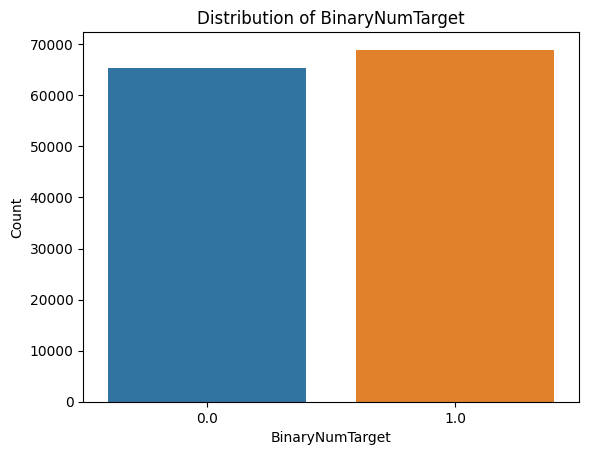

In [651]:
# Plot target variable distribution
sns.countplot(x='BinaryNumTarget', data=data)
plt.xlabel('BinaryNumTarget')
plt.ylabel('Count')
plt.title('Distribution of BinaryNumTarget')
plt.show()

In [652]:
data['BinaryNumTarget'].value_counts()

BinaryNumTarget
1.0    68930
0.0    65268
Name: count, dtype: int64

In [653]:
# Separate majority and minority classes
df_majority = data[data['BinaryNumTarget'] == 0]
df_minority = data[data['BinaryNumTarget'] == 1]

In [654]:
# If the minority class is larger than the majority class, swap them
if len(df_minority) > len(df_majority):
    df_majority, df_minority = df_minority, df_majority

In [655]:
from sklearn.utils import resample


In [656]:
# Undersample the majority class to the size of the minority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,  # sample without replacement
                                   n_samples=min(len(df_majority), len(df_minority)),  # use the size of the smaller class
                                   random_state=42)  # reproducible results

In [657]:
# Combine the downsampled majority class with the minority class
data = pd.concat([df_majority_downsampled, df_minority])

In [658]:
# Shuffle the dataset to mix the majority and minority classes
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

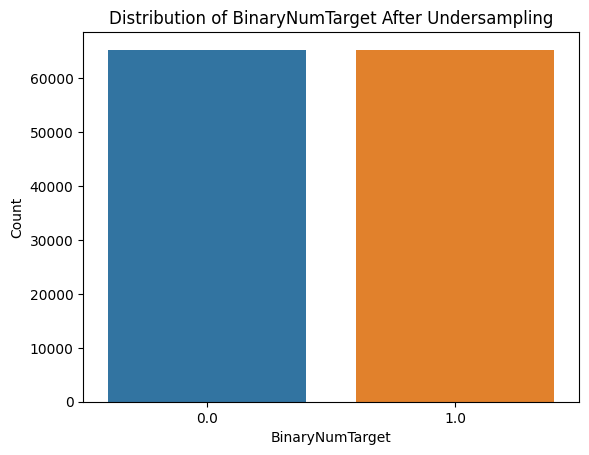

BinaryNumTarget
1.0    65268
0.0    65268
Name: count, dtype: int64


In [659]:
# Plot the new target variable distribution
sns.countplot(x='BinaryNumTarget', data=data)
plt.xlabel('BinaryNumTarget')
plt.ylabel('Count')
plt.title('Distribution of BinaryNumTarget After Undersampling')
plt.show()

# Check the distribution
print(data['BinaryNumTarget'].value_counts())

In [660]:
# Prepare tweet data for model
max_words = 1000  # Max number of words to keep in Tokenizer
max_seq_length = 100  # Max sequence length for padding


In [661]:
import re

def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = text.lower().strip()  # Convert to lowercase and strip leading/trailing spaces
    return text

data['tweet'] = data['tweet'].apply(clean_text)

In [662]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['tweet'])
sequences = tokenizer.texts_to_sequences(data['tweet'])
word_index = tokenizer.word_index

tweet_data = pad_sequences(sequences, maxlen=max_seq_length)

In [663]:
# Target variable
target = data['BinaryNumTarget'].values

In [664]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(tweet_data, target, test_size=0.2, random_state=42)

In [665]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Attention

In [666]:
from tensorflow.keras import regularizers


In [667]:
# RNN Model Architecture
# Input layer
text_input = Input(shape=(max_seq_length,))

# Embedding layer
embedding_layer = Embedding(max_words, 100)(text_input)

# Bidirectional LSTM layers with return sequences for attention
bi_lstm_layer_1 = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
dropout_1 = Dropout(0.5)(bi_lstm_layer_1)

bi_lstm_layer_2 = Bidirectional(LSTM(64, return_sequences=True))(dropout_1)
dropout_2 = Dropout(0.5)(bi_lstm_layer_2)

# Attention mechanism
attention_output = Attention()([bi_lstm_layer_2, bi_lstm_layer_2])

# LSTM layer to process the attention output
lstm_layer = LSTM(64, return_sequences=False)(attention_output)
dropout_3 = Dropout(0.5)(lstm_layer)

# Dense layers with L2 regularization
dense_layer_1 = Dense(128, activation='relu', 
                      kernel_regularizer=regularizers.l2(0.01))(dropout_3)
dropout_4 = Dropout(0.5)(dense_layer_1)

dense_layer_2 = Dense(64, activation='relu', 
                      kernel_regularizer=regularizers.l2(0.01))(dropout_4)
dropout_5 = Dropout(0.5)(dense_layer_2)

# Output layer (binary classification)
output_layer = Dense(1, activation='sigmoid')(dropout_5)


In [668]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001)

In [669]:
model = Model(inputs=text_input, outputs=output_layer)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [670]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# Combine both callbacks
callbacks = [early_stopping, reduce_lr]

# Train the model
history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=70, 
                    batch_size=32, 
                    callbacks=callbacks)

Epoch 1/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 100s 36ms/step - accuracy: 0.5487 - loss: 1.4361 - val_accuracy: 0.9047 - val_loss: 0.2815 - learning_rate: 1.0000e-04
Epoch 2/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 95s 36ms/step - accuracy: 0.9138 - loss: 0.2659 - val_accuracy: 0.9245 - val_loss: 0.2199 - learning_rate: 1.0000e-04
Epoch 3/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 95s 36ms/step - accuracy: 0.9276 - loss: 0.2245 - val_accuracy: 0.9252 - val_loss: 0.2174 - learning_rate: 1.0000e-04
Epoch 4/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 95s 36ms/step - accuracy: 0.9308 - loss: 0.2149 - val_accuracy: 0.9271 - val_loss: 0.2079 - learning_rate: 1.0000e-04
Epoch 5/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 94s 36ms/step - accuracy: 0.9335 - loss: 0.2032 - val_accuracy: 0.9305 - val_loss: 0.1995 - learning_rate: 1.0000e-04
Epoch 6/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 92s 35ms/step - accuracy: 0.9338 - loss: 0.1985 - val_accuracy: 0.9308 - val_loss: 0.1964 - learning_rate: 1.0000e-04
Epoch 7/70
2611/2611 ━━━━━━━━━━━━━━━━━━

In [671]:
# Print validation accuracy for each epoch
val_accuracy = history.history['val_accuracy']
print("Validation Accuracy for each epoch:")
for epoch, accuracy in enumerate(val_accuracy, 1):
    print(f"Epoch {epoch}: {accuracy:.4f}")

# Print final validation accuracy
final_val_accuracy = val_accuracy[-1]
print(f'Final Validation Accuracy: {final_val_accuracy:.4f}')

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Validation Accuracy for each epoch:
Epoch 1: 0.9047
Epoch 2: 0.9245
Epoch 3: 0.9252
Epoch 4: 0.9271
Epoch 5: 0.9305
Epoch 6: 0.9308
Epoch 7: 0.9320
Epoch 8: 0.9322
Epoch 9: 0.9339
Epoch 10: 0.9347
Epoch 11: 0.9336
Epoch 12: 0.9345
Epoch 13: 0.9345
Epoch 14: 0.9358
Epoch 15: 0.9363
Epoch 16: 0.9360
Epoch 17: 0.9368
Epoch 18: 0.9379
Epoch 19: 0.9357
Epoch 20: 0.9374
Epoch 21: 0.9381
Epoch 22: 0.9389
Final Validation Accuracy: 0.9389
816/816 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9378 - loss: 0.1728
Test Accuracy: 93.62%


In [672]:
# Define the function to get relevant news URLs
def get_relevant_urls(tweet_text):
    api_key = '06cba0dcd3d84dc3bc34aac90e62ba89'  # Replace with your actual NewsAPI.org API key
    url = f'https://newsapi.org/v2/everything?q={tweet_text}&sortBy=relevancy&apiKey={api_key}'

    response = requests.get(url)
    response_data = response.json()

    try:
        articles = response_data['articles']
    except KeyError:
        print("Error: The 'articles' key was not found in the API response.")
        return []

    urls = [article.get('url', '') for article in articles]
    return urls

In [673]:
# Example for new texts
new_texts = [
  "Sri Lanka faces a crucial challenge as they head into the second Test against England on Thursday at Lord’s, a venue that has often served as an unlikely home away from home for the visiting side."
 ]

In [674]:
# Preprocess the new texts
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_data = pad_sequences(new_sequences, maxlen=max_seq_length)

In [675]:
# Get predictions and news URLs
new_predictions = model.predict(new_data)
predicted_classes = (new_predictions > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


In [676]:
for text, prediction in zip(new_texts, predicted_classes):
    print(f"Tweet: {text}")
    print(f"Prediction: {'Positive' if prediction == 1 else 'Negative'}")
    urls = get_relevant_urls(text)
    print(f"Relevant News URLs: {urls}")
    print()

Tweet: Sri Lanka faces a crucial challenge as they head into the second Test against England on Thursday at Lord’s, a venue that has often served as an unlikely home away from home for the visiting side.
Prediction: Negative
Relevant News URLs: []



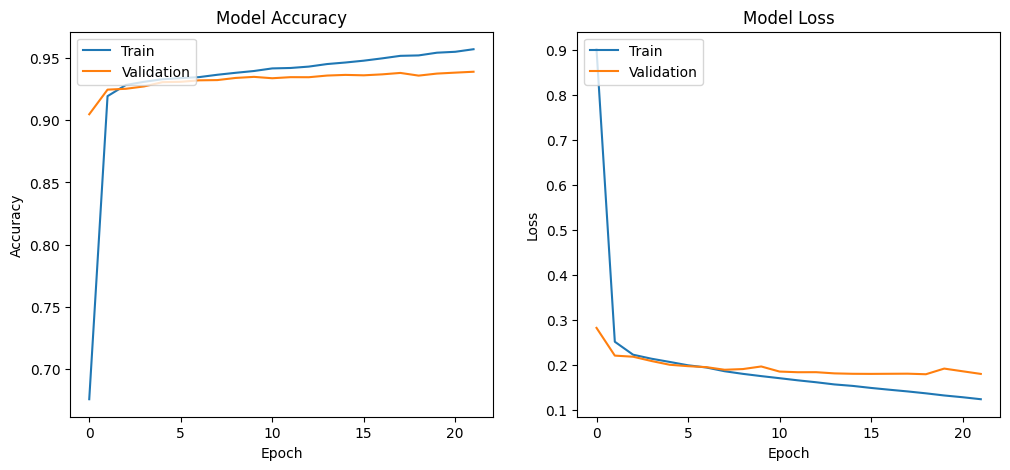

In [677]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

816/816 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step


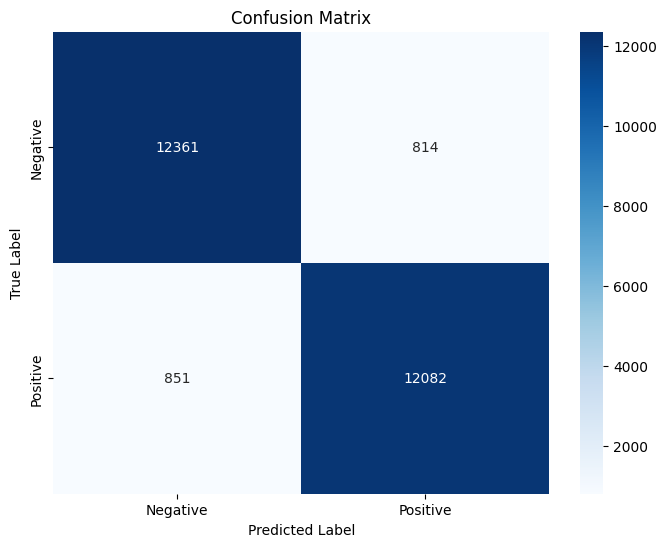

              precision    recall  f1-score   support

    Negative       0.94      0.94      0.94     13175
    Positive       0.94      0.93      0.94     12933

    accuracy                           0.94     26108
   macro avg       0.94      0.94      0.94     26108
weighted avg       0.94      0.94      0.94     26108



In [678]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Make predictions on the test set
y_pred_prob = model.predict(X_test)

# Step 2: Convert probabilities to binary labels
y_pred = (y_pred_prob > 0.5).astype(int)

# Step 3: Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Step 4: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Optional: Print a classification report for detailed metrics
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


In [679]:
model.save('verity_function3.h5')

Retraining

In [680]:
from tensorflow.keras.models import load_model

# Load the saved model
model2 = load_model('/kaggle/working/verity_function3.h5')

In [681]:
# Load dataset from a local CSV file
custom_data = pd.read_csv('/kaggle/input/verityf3sldata/Function3_data.csv')

# Display the first few rows to check if it's loaded correctly
custom_data.head()

,heading,content,label,Word count,Max word length,Min word length,Average word length,present_verbs,past_verbs,adjectives,...,PERSON,ORDINAL,TIME,NORP,FAC,WORK_OF_ART,MONEY,PERCENT,LAW,LANGUAGE
0,New largest dinosaur species found in Australi...,Scientists in Australia lack declassify a old ...,1,379.0,16.0,1.0,5.242744,47.0,0.0,40.0,...,5.405405,2.702703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SAITM issue: President to discuss with stakeho...,President Maithripala Sirisena disinherit summ...,1,117.0,20.0,1.0,5.683761,22.0,0.0,6.0,...,25.000000,NaN,12.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Intern’l responsibilities crucial for developm...,Norwegian Prime Minister Erna Solberg said tod...,1,251.0,16.0,1.0,5.840637,38.0,0.0,27.0,...,25.000000,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,Five remanded over assault on Sri Lankan HC,"Five people , who differ arrested for allegedl...",1,126.0,14.0,1.0,5.214286,17.0,0.0,6.0,...,17.391304,NaN,4.347826,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Banners with LTTE chief's pic land duo in jail,Two nonmember of a fringe Tamil nationalist pa...,1,169.0,12.0,1.0,5.313609,23.0,0.0,11.0,...,25.000000,3.571429,NaN,3.571429,3.571429,NaN,NaN,NaN,NaN,NaN


In [682]:
# Ensure 'text' column contains strings
custom_data['content'] = custom_data['content'].astype(str)

# Replace NaN or missing values with empty strings
custom_data['content'] = custom_data['content'].fillna('')

In [683]:
# Ensure 'text' column contains strings
custom_data['content'] = custom_data['content'].astype(str)

# Replace NaN or missing values with empty strings
custom_data['content'] = custom_data['content'].fillna('')

In [684]:
custom_data['label'].value_counts()

label
0    856
1    500
Name: count, dtype: int64

In [685]:
# Clean and preprocess the data
def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = text.lower().strip()  # Convert to lowercase and strip leading/trailing spaces
    return text

custom_data['content'] = custom_data['content'].apply(clean_text)


In [686]:
x_balanced1 = custom_data.drop(columns=['label'])
y_balanced1 = custom_data['label']

In [687]:
# Tokenizer and padding
tokenizer1 = Tokenizer(num_words=max_words)
tokenizer1.fit_on_texts(custom_data['content'])
sequences1 = tokenizer1.texts_to_sequences(custom_data['content'])
tweet_data1 = pad_sequences(sequences1, maxlen=max_seq_length)

# Target variable
target1 = y_balanced1.values

In [688]:
import pickle
with open('function3_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [689]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(tweet_data1, target1, test_size=0.2, random_state=42)


In [690]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [691]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model (ensure it uses the same configuration as before)
model2.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])  # Change to a less suitable loss function

# Train the model with custom data
callbacks = [EarlyStopping(patience=2, monitor='val_loss', restore_best_weights=True)]
history2 = model2.fit(X_train1, y_train1, epochs=10, batch_size=64,
                    validation_split=0.2, callbacks=callbacks)


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.5109 - loss: 0.3909 - val_accuracy: 0.6313 - val_loss: 0.2620
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6625 - loss: 0.2391 - val_accuracy: 0.6498 - val_loss: 0.2116
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6982 - loss: 0.1979 - val_accuracy: 0.7235 - val_loss: 0.1865
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7671 - loss: 0.1675 - val_accuracy: 0.8111 - val_loss: 0.1549
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8689 - loss: 0.1251 - val_accuracy: 0.8341 - val_loss: 0.1281
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9112 - loss: 0.0866 - val_accuracy: 0.8756 - val_loss: 0.0910
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9295 - loss: 0.0696 - val_accuracy: 0.9032 - val_loss: 0.0753
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9562 - loss: 0.0542 - val_accuracy: 0.9171 - v

In [692]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model
loss, accuracy = model2.evaluate(X_test1, y_test1)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9360 - loss: 0.0585
Test Accuracy: 94.12%


In [693]:
# Make predictions on the test set
y_pred_prob1 = model2.predict(X_test1)
y_pred1 = (y_pred_prob1 > 0.5).astype(int)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test1, y_pred1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


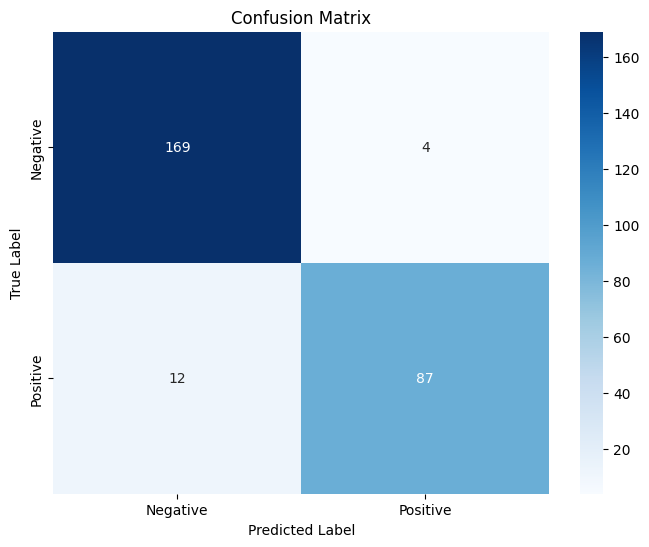

              precision    recall  f1-score   support

    Negative       0.93      0.98      0.95       173
    Positive       0.96      0.88      0.92        99

    accuracy                           0.94       272
   macro avg       0.94      0.93      0.94       272
weighted avg       0.94      0.94      0.94       272



In [694]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report
print(classification_report(y_test1, y_pred1, target_names=['Negative', 'Positive']))

In [695]:
# Save the retrained model
model2.save('verity_function3_retrained.h5')

testing

In [696]:
from tensorflow.keras.models import load_model

# Load the saved retrained model
model_retrained = load_model('/kaggle/working/verity_function3_retrained.h5')

In [721]:
# Example new news article (replace this with the actual text)
new_article2 = "One of the latest notable developments is the publication of the 2024 Arctic Strategy by the U.S. Department of Defense. This strategy addresses the growing security challenges in the Arctic region, which is rapidly changing both strategically and environmentally. The strategy highlights the increasing influence of China and Russia in the Arctic and emphasizes the importance of U.S. defense and security commitments in the region. It also underscores collaboration with NATO, especially with the addition of Finland and Sweden to the alliance. This new strategy builds upon the 2022 National Security and Arctic Region strategies, focusing on maintaining Arctic stability amidst climate change and geopolitical shifts​"

In [722]:
# Clean the text using the same function
def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = text.lower().strip()  # Convert to lowercase and strip leading/trailing spaces
    return text

cleaned_article = clean_text(new_article2)

# Tokenize and pad the text using the tokenizer you fitted earlier
# Load the tokenizer if you saved it earlier
with open('function3_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Convert text to sequences
article_sequence = tokenizer.texts_to_sequences([cleaned_article])

# Pad the sequence to match the training input shape
padded_article = pad_sequences(article_sequence, maxlen=max_seq_length)


In [723]:
# Make prediction
prediction_prob = model_retrained.predict(padded_article)

# Convert probability to a binary prediction (1 or 0)
prediction = (prediction_prob > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [724]:
print(prediction_prob)

[[0.02464691]]
